In [1]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import GradScaler, autocast        
from torch.optim.lr_scheduler import CosineAnnealingLR  
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from yacs.config import CfgNode as CN

from data import make_dataset, transform_map
from eval import evaluate
from model import UModel
from torch_utils import ema_update, freeze_layers
from utils import setup, clean_exp_savedir


In [2]:
cfg = CN(new_allowed=True)
cfg.merge_from_file("config.yaml")

source_train_loader, target_train_loader, source_test_loader, target_test_loader = (
    make_dataset(
        source_dataset=cfg.dataset.source,
        target_dataset=cfg.dataset.target,
        imgsize=cfg.img_size,
        train_bs=cfg.domain_adapt.train_bs,
        eval_bs=cfg.domain_adapt.eval_bs,
        num_workers=cfg.domain_adapt.num_workers,
    )
)


model = UModel(
    backbone=cfg.model.backbone.type,
    hidden_dim=cfg.model.backbone.hidden_dim,
    out_dim=cfg.dataset.num_classes,
    imgsize=cfg.img_size,
    freeze_backbone=cfg.model.backbone.freeze,
)

device = torch.device(cfg.device)
ckpt = torch.load("runs/new_16_10/nN5GU6/da_best_63.74.pth")
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)

Loaded pretrained weights.


In [16]:
source_data = next(iter(source_train_loader))
target_data = next(iter(target_train_loader))
_, src_k_data, src_labels, _ = source_data
tgt_q_data, tgt_k_data, _, affine_params = target_data

src_img = src_k_data.to(device)
src_labels = src_labels.to(device)
tgt_k_img = tgt_k_data.to(device)  # strong
tgt_q_img = tgt_q_data.to(device)  # weak

In [17]:
from model import EigenCAM
from data import transform_map

cam1 = EigenCAM(model.backbone, target_layer=model.backbone.transformer.blocks[-1].norm2)
cam1.register_hook()

with torch.no_grad():
    logit_t_q  = model(tgt_q_img, branch="tch")
    probs_t_q = F.softmax(logit_t_q, dim=1)
    pseudo_labels = probs_t_q.argmax(dim=1)

    salience_map1 = cam1(x=tgt_q_img)
    salience_map_transformed11 = transform_map(
        salience_map1, affine_params, transform_params=[0.9,0.3], imgsize=cfg.img_size
    )

In [8]:
import matplotlib.pyplot as plt
def show_object(obj:torch.Tensor):
    obj = obj.cpu().numpy()
    obj = obj.transpose(1, 2, 0)
    obj = obj * 255.0
    obj = obj.astype(np.uint8)
    plt.imshow(obj)
    plt.show()

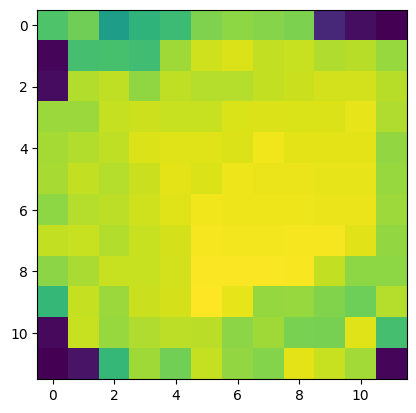

In [18]:
show_object(salience_map1[0].unsqueeze(0))

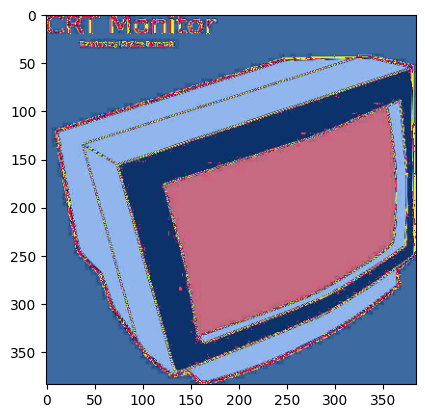

In [19]:
show_object(tgt_q_img[0])

In [32]:
cam2 = EigenCAM(model, target_layer=model.backbone.transformer.blocks[-1].norm2)
cam2.register_hook()

with torch.no_grad():
    logit_t_q  = model(tgt_q_img, branch="tch")
    probs_t_q = F.softmax(logit_t_q, dim=1)
    pseudo_labels = probs_t_q.argmax(dim=1)

    salience_map2 = cam2(x=tgt_q_img, branch="tch")
    salience_map_transformed2 = transform_map(
        salience_map2, affine_params, transform_params=[1.0,0.0], imgsize=cfg.img_size
    )

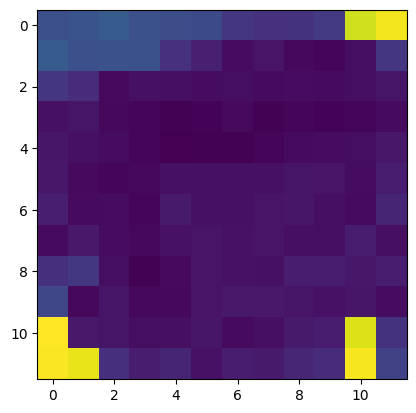

In [33]:
show_object(salience_map2[0].unsqueeze(0))

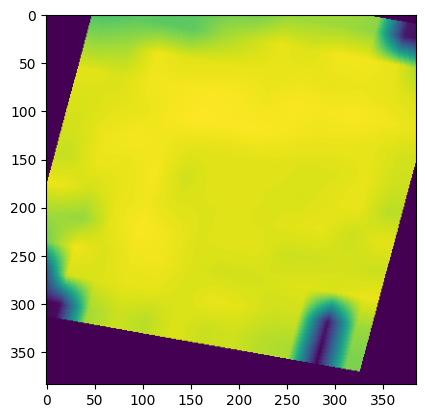

In [34]:
show_object(salience_map_transformed2[0])

In [36]:
show_object((tgt_q_img+ F.interpolate(salience_map2, size=(cfg.img_size, cfg.img_size), mode='bilinear', align_corners=False))[0])

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [12] and output size of (384, 384). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.